### Import Libraries

In [ ]:
import random
from operator import add
from typing import TypedDict, Literal, Annotated, Literal, List
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

### Workflows

#### Sequential Processing

**Sequential workflows** are simple because each node modifies the state one after another.

**1. State Schema**

In [2]:
class State(TypedDict):
    input: int
    output: int

In [3]:
workflow = StateGraph(state_schema=State)

**2. Nodes**

In [4]:
def node_a(state: State)->State:
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return State(output=output)

def node_b(state: State):
    input_value = state['output']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

In [5]:
workflow.add_node(node_a)
workflow.add_node(node_b)

**3. Edges**

In [6]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

**4. Compile and Run**

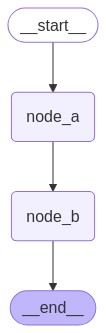

In [7]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [8]:
graph.invoke(
    input = {
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:5
 ->output:6
 
NODE B:
 ->input:6
 ->offset:7
 ->output:13
 


{'input': 1, 'output': 13}

#### Sequential Processing With Configs

- **RunnableConfig** is used to inject external parameters during workflow execution.
- Configs enhance flexibility by making workflows adaptable to different contexts 
without rewriting code.
- They allow external information—such as API results, database fields, or user session data—to influence the workflow's behavior dynamically.

**1. State Schema**

In [9]:
class State(TypedDict):
    input: int
    partial: Annotated[List[int], add]
    results: Annotated[List[int], add]

**2. Nodes**

In [10]:
def node_a(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['input'] + partial
    print(
        f"NODE A:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [11]:
def node_b(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['results'][-1] + partial
    print(
        f"NODE B:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [12]:
workflow = StateGraph(State)

workflow.add_node(node_a)
workflow.add_node(node_b)

**3. Edges**

In [13]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

**4. Compile and Run**

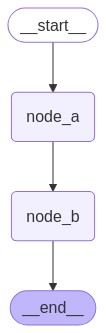

In [14]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [15]:
config = {"configurable": {"offset": 20}}
graph.invoke(
    input = {
        "input": 1,
    }, 
    config = config,
)

NODE A:
 ->input:1
 ->offset:20
 ->random:6
 ->partial:26
 ->output:27
 
NODE B:
 ->input:27
 ->offset:20
 ->random:7
 ->partial:27
 ->output:54
 


{'input': 1, 'partial': [26, 27], 'results': [27, 54]}

#### Parallel Processing with Reducer

**Parallel workflows** require reducers to avoid update conflicts.

**Without reducer**

Changing the workflow so `start` sends the state to both `node_a` and `node_b` in parallel causes a problem:

- Both nodes try to update the `output` field at the same time.
- Results in an **InvalidUpdateError** because the output field was designed to store only a single integer.

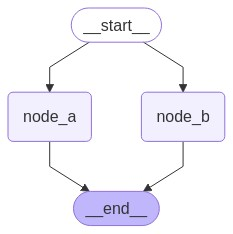

In [16]:
class State(TypedDict):
    input: int
    output: int

def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": output}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [17]:
try:
    graph.invoke(
        input = {
            "input": 1,
        }, 
    )
except Exception as e:
    print(e)

NODE A:
 ->input:1
 ->offset:1
 ->output:2
 NODE B:
 ->input:1
 ->offset:7
 ->output:8
 

At key 'output': Can receive only one value per step. Use an Annotated key to handle multiple values.


**With Reducer**

Reducers resolve conflicts by defining how to combine multiple updates to the same field.

In [18]:
add([1,2,3],[4,5,6])

[1, 2, 3, 4, 5, 6]

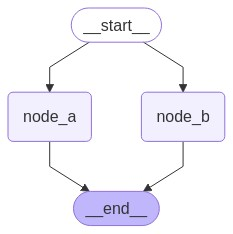

In [19]:
class State(TypedDict):
    input: int
    output: Annotated[List[int], add]

def node_a(state: State):
    input_value = state['input']
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE A:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints

def node_b(state: State):
    input_value = state['input'] # Coming from input
    offset = random.randint(1,10)
    output =  input_value + offset
    print(
        f"NODE B:\n "
        f"->input:{input_value}\n " 
        f"->offset:{offset}\n "
        f"->output:{output}\n "
    )
    return {"output": [output]} # now it's a List of ints


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge(START, "node_b")
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [20]:
graph.invoke(
    input = {
        "input": 1,
    }, 
)

NODE B:
 ->input:1
 ->offset:7
 ->output:8
 NODE A:
 ->input:1
 ->offset:5
 ->output:6
 



{'input': 1, 'output': [6, 8]}

#### Conditional Router

**1. State Schema**

In [21]:
class State(TypedDict):
    input: str
    action: Literal["reverse", "upper"]
    output: str

In [22]:
workflow = StateGraph(State)

**2. Nodes**

In [23]:
def node_a(state: State):
    print("Node A\n")
    output =  state['input'][::-1]
    print(f"output: {output}")
    return {"output": output}

def node_b(state: State):
    print("Node B\n")
    output = state['input'].upper()
    print(f"output: {output}")
    return {"output": output}

workflow.add_node(node_a)
workflow.add_node(node_b)


**3. Routing Function**

In [24]:
def routing_function(state: State):
    action = state["action"]
    if action == "reverse":
        return "node_a"
    if action == "upper":
        return "node_b"

**4. Edges**

Use conditional edges to control the flow of data:

- START → routing_function to decide the path.
- node_a → END for reverse.
- node_b → END for uppercase.

In add_conditional_edges() method, use source, path and path_map as the necessary arguments for routing.

In [25]:
workflow.add_conditional_edges(
    source=START, 
    path=routing_function, 
    path_map=["node_a", "node_b"]
)

workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)

**5. Compile and Run**

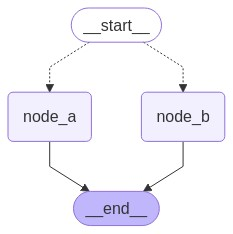

In [26]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [27]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "upper",
    }, 
)

Node B

output: SOME INPUT


{'input': 'Some input', 'action': 'upper', 'output': 'SOME INPUT'}

In [28]:
graph.invoke(
    input = {
        "input": "Some input",
        "action": "reverse",
    }, 
)

Node A

output: tupni emoS


{'input': 'Some input', 'action': 'reverse', 'output': 'tupni emoS'}